## Transform reviews and EDA
In this notebook, we take our filtered reviews by year and apply various transformations to our reviews. The idea is to go from a raw review and have a numeric representation before we apply machine learning techniques that can group and extract common themes. The following are steps in this notebook:
- Preprocess: Remove HTML tags, Expand Contractions, Replace accented characters, Lower case and collapse whitespaces
- Tokenize and Lemmatize
- Perform EDA tasks
- Term Frequency Analysis as an extension of EDA, including, word counts, word cloud and so on.

### 1. Import Libraries

In [1]:
import os
os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, to_date, pandas_udf, StringType, size, split
import spacy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from collections import Counter

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

import gensim.downloader as api
from wordcloud import WordCloud

from nlp_preprocessor import text_preprocessor

### 2. Start Spark Session

In [2]:
# Initialize Spark Session with Increased Driver Memory
spark = SparkSession.builder \
    .appName('ReviewsProcessing') \
    .config('spark.driver.memory', '8g') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/11/03 00:33:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### 3. Load Reviews

In [3]:
# Read in reviews data
reviews_2022_df = spark.read.parquet("filtered/yelp_reviews_2022.parquet")

In [4]:
reviews_2022_df.show()

+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+----+--------------------+-------------+
|           review_id|             user_id|         business_id|stars|useful|funny|cool|                text|               date|year|          categories|business_open|
+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+----+--------------------+-------------+
|mG1FavLfA5j2L83sC...|BLu9dc1uj_MBgR-Ns...|drTZrkbpSoJgwKETl...|  1.0|     0|    0|   0|I bought a Fender...|2022-01-01 15:47:07|2022|Shopping, Musical...|            1|
|WMpnr1XBJ5U38rfSd...|0w1Cpzqg0LV93LmrW...|jyxHti29yWdYR00It...|  5.0|     0|    0|   0|This is our go to...|2022-01-02 03:49:01|2022|Restaurants, Medi...|            1|
|99EMi0lRhdmylbG0s...|QcP1iT3zKu7NQmiIl...|Jo4ei-c-5H53IxZxA...|  5.0|     0|    0|   0|Danielle did a gr...|2022-01-03 03:17:03|2022|Hair Salons, Men

#### Qn: How many reviews have no text?

In [5]:
reviews_2022_df.filter((reviews_2022_df.text.isNull()) | (reviews_2022_df.text == '')).count()

0

### 4. Preprocess Review Text
Remove HTML tags, expand contractions, fix accented characters, lower case and remove unnecessary whitespace

In [1]:
# Preprocess user review text
@pandas_udf(StringType())
def preprocess_text(reviews):
    return reviews.apply(lambda r: text_preprocessor(r))

NameError: name 'pandas_udf' is not defined

In [7]:
cleaned_df = reviews_2022_df.withColumn('review_cleaned', preprocess_text(reviews_2022_df.text))

In [8]:
cleaned_df.select('text', 'review_cleaned').show(5)

[Stage 7:=======================================>                   (2 + 1) / 3]

+--------------------+--------------------+
|                text|      review_cleaned|
+--------------------+--------------------+
|I bought a Fender...|i bought a fender...|
|This is our go to...|this is our go to...|
|Danielle did a gr...|danielle did a gr...|
|We saw a lot of r...|we saw a lot of r...|
|We  Ordered pork ...|we ordered pork f...|
+--------------------+--------------------+
only showing top 5 rows



### 5. a. Lemmatize Reviews (spacy)
We tokenize each review into words, and keep words that carry semantic meaning. We normalize these words into their base form to eliminate redundant meaning.

In [9]:
# Process cleaned user reviews, preserve negation
negations = {'no', 'not', 'never'}

# spacy is popular with a variety of languages, love the lemmatizer as part of the pipeline
@pandas_udf(StringType())
def spacy_lemmatize_text(reviews):
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
    return reviews.apply(lambda r: ' '.join([token.lemma_ for token in nlp(r) if token.is_alpha and (not token.is_stop or token in negations)]))

In [10]:
processed_df = cleaned_df.withColumn('lemmas', spacy_lemmatize_text(cleaned_df['review_cleaned']))

In [11]:
# Cache computed result for fast retrieval downstream
processed_df.cache()

DataFrame[review_id: string, user_id: string, business_id: string, stars: double, useful: bigint, funny: bigint, cool: bigint, text: string, date: string, year: int, categories: string, business_open: bigint, review_cleaned: string, lemmas: string]

In [12]:
# Trigger caching
# processed_df.count()

#### b. Add column: Number of lemmas extracted from review

In [13]:
# Calculate num of lemmas extracted
processed_df = processed_df.withColumn('num_lemmas', size(split(processed_df['lemmas'], ' ')))

In [14]:
reviews_pandas_df = processed_df.select('review_id', 'business_id', 'stars', 'categories', 'date', 'text', 'lemmas', 'num_lemmas').toPandas()

In [15]:
reviews_pandas_df.head()

,review_id,business_id,stars,categories,date,text,lemmas,num_lemmas
0,mG1FavLfA5j2L83sCZ3rFg,drTZrkbpSoJgwKETlFbc3w,1.0,"Shopping, Musical Instrument Services, Musical...",2022-01-01 15:47:07,I bought a Fender 1966 Telecaster that the sal...,buy fender telecaster salesperson tell origina...,50
1,WMpnr1XBJ5U38rfSdErhJQ,jyxHti29yWdYR00Itt1A2w,5.0,"Restaurants, Mediterranean",2022-01-02 03:49:01,This is our go to for take out when I visit my...,visit son restaurant desert home food authenti...,14
2,99EMi0lRhdmylbG0soaf9w,Jo4ei-c-5H53IxZxAVf1jQ,5.0,"Hair Salons, Men's Hair Salons, Barbers, Beaut...",2022-01-03 03:17:03,Danielle did a great job! She listened and cu...,danielle great job listen cut hair way request...,24
3,Qs4z8e7hCoU9EzRKD9rGPQ,YT5CjacTllBtvMaMJS3IbA,1.0,"Hotels & Travel, Hotels, Venues & Event Spaces...",2022-01-05 15:55:59,We saw a lot of roaches in the bathroom when w...,see lot roach bathroom wake bed large dark sta...,38
4,SXZ2Nw9UGAgPlXJsju9fFA,9MHe5jAym2d8VhT_NbCRyw,2.0,"Restaurants, Chinese, Thai",2022-01-06 03:59:21,We Ordered pork fried rice and beef chow mei ...,order pork fry rice beef chow mei fun teriyaki...,16


In [16]:
# find how many unique business categories exist
category_list = reviews_pandas_df['categories'].tolist()
len(category_list)

31571

#### Qn: How many unique categories exist?
We might reframe our capstone goal to account for type of business. It's a good idea to go ahead and have a look at the categories column.  

In [17]:
all_categories = []
for cat in category_list:
    if isinstance(cat, str) and len(cat.strip()) > 0:
        all_categories += (cat.split(','))
unique_categories = set(cat.strip() for cat in all_categories)
len(unique_categories)

1075

### 5. EDA
We perform basic statistical summaries to understand how much data is missing, column types, and distributions

In [18]:
reviews_pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31571 entries, 0 to 31570
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    31571 non-null  object 
 1   business_id  31571 non-null  object 
 2   stars        31571 non-null  float64
 3   categories   31561 non-null  object 
 4   date         31571 non-null  object 
 5   text         31571 non-null  object 
 6   lemmas       31571 non-null  object 
 7   num_lemmas   31571 non-null  int32  
dtypes: float64(1), int32(1), object(6)
memory usage: 1.8+ MB


In [19]:
# Star rating is categorical
reviews_pandas_df['stars'] = reviews_pandas_df.stars.astype('category')
reviews_pandas_df.describe()

,num_lemmas
count,31571.000000
mean,40.130563
std,36.418088
min,1.000000
25%,17.000000
50%,29.000000
75%,50.000000
max,520.000000


#### Qn: What is the distribution of count of reviews month over month?

In [20]:
# Extract month - All reviews are from Jan 2022
reviews_pandas_df["date"] = pd.to_datetime(reviews_pandas_df.date, errors='coerce')
reviews_pandas_df["month"] = reviews_pandas_df.date.dt.month
reviews_pandas_df.head()

reviews_pandas_df["month"].value_counts()

month
1    31571
Name: count, dtype: int64

#### Qn: What is the review length distribution?

<Figure size 1000x800 with 0 Axes>

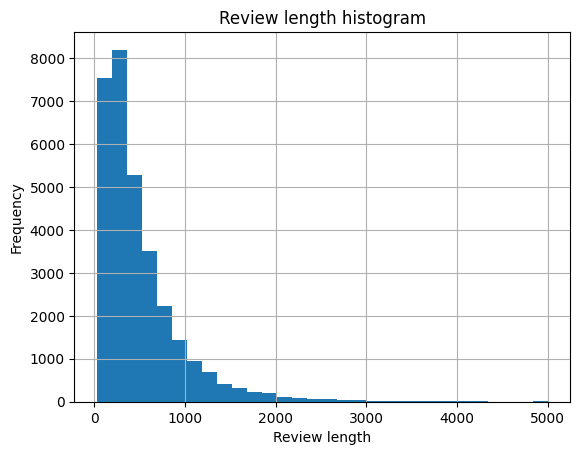

In [21]:
# Distribution of review length
reviews_pandas_df['review_length'] = reviews_pandas_df.text.apply(len)

plt.figure(figsize=(10,8))
reviews_pandas_df.hist('review_length', bins=30)
plt.xlabel('Review length')
plt.ylabel('Frequency')
plt.title('Review length histogram')
plt.show()

A histogram plot of number of lemmas would be expected to mirror that of review length as shown below

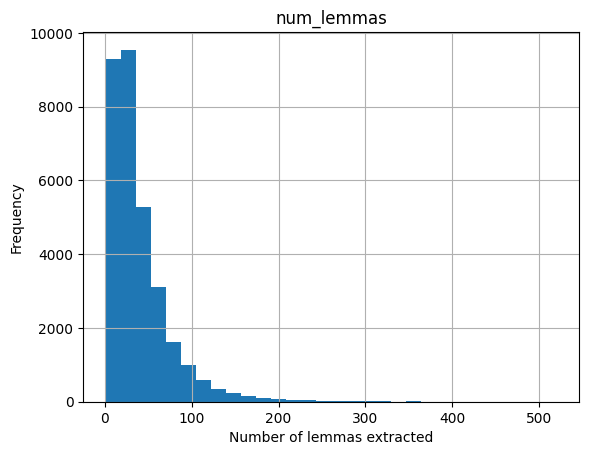

In [22]:
# EDA
# Distribution of num of lemmas
reviews_pandas_df.hist('num_lemmas', bins=30)
plt.xlabel('Number of lemmas extracted')
plt.ylabel('Frequency')
plt.show()

#### Qn: Does review length vary with star rating?

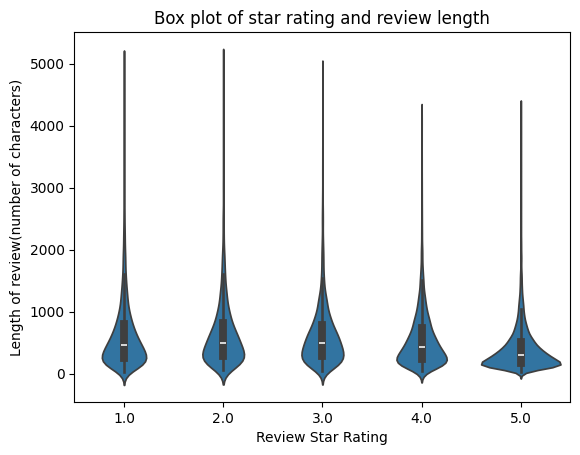

In [23]:
sns.violinplot(x='stars', y='review_length', data=reviews_pandas_df)
plt.xlabel('Review Star Rating')
plt.ylabel('Length of review(number of characters)')
plt.title('Box plot of star rating and review length')
plt.show()

/var/folders/66/hjdps8cj0sd_nt4v35d18wzc0000gn/T/ipykernel_84579/259855323.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = reviews_pandas_df.groupby("stars")["review_length"].mean().reset_index()


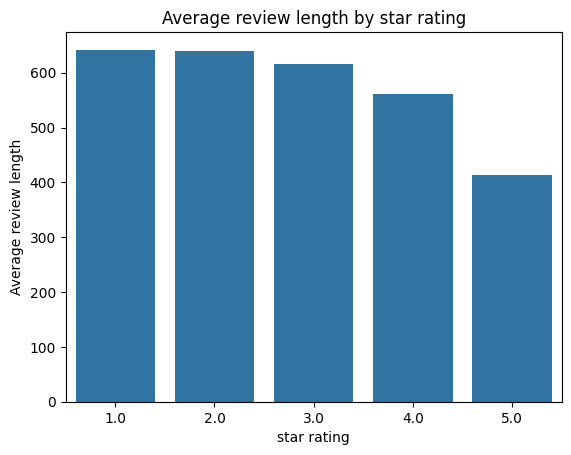

In [24]:
summary = reviews_pandas_df.groupby("stars")["review_length"].mean().reset_index()
summary.rename(columns={'review_length': 'average_review_length'}, inplace=True)

sns.barplot(x='stars', y='average_review_length', data=summary)
plt.title('Average review length by star rating')
plt.xlabel('star rating')
plt.ylabel('Average review length')
plt.show()

#### Observation: It seems 5 star rated reviews tend to be shorter than less rated reviews as shown in the violinplot and barplot above.

In [25]:
reviews_pandas_df.num_lemmas.sort_values(ascending=False)

15628    520
5719     419
21148    410
7201     398
21012    396
        ... 
3392       3
20730      3
15973      2
2701       2
21013      1
Name: num_lemmas, Length: 31571, dtype: int32

In [26]:
# Stars value_counts
reviews_pandas_df.value_counts('stars', ascending=False)

stars
5.0    16528
1.0     6578
4.0     4341
3.0     2172
2.0     1952
Name: count, dtype: int64

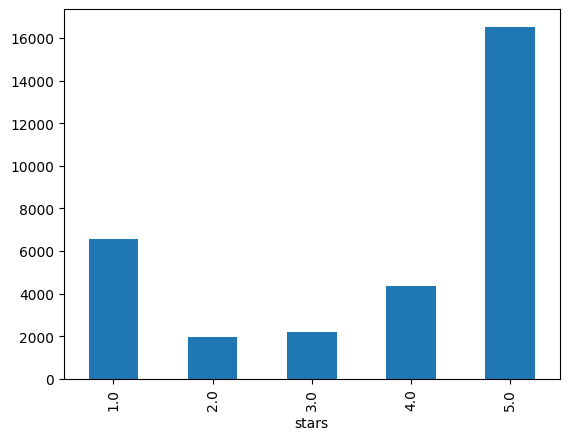

In [27]:
# Bar plot stars
reviews_pandas_df.value_counts('stars').sort_index().plot(kind='bar')
plt.show()

In [28]:
# Average word length for each review
reviews_pandas_df['avg_word_length'] = reviews_pandas_df.text.apply(lambda r: np.round(np.mean([len(word) for word in r.split()])))
reviews_pandas_df.sort_values('avg_word_length', ascending=False).head()

,review_id,business_id,stars,categories,date,text,lemmas,num_lemmas,month,review_length,avg_word_length
21013,FYzZvSvAZSSXnhDuOmcRQA,Kg1bt3WU3QA39rO_Nk7k7g,5.0,"Chinese, Restaurants",2022-01-17 05:36:19,Yummmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...,yummmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...,1,1,85,85.0
14659,ioiszeS2CSk8KyEy61Debw,1s8WJM2zbUScgZ-7HlMXuA,1.0,"Pizza, Restaurants, Italian",2022-01-18 23:07:18,Terrible pizza. Xxxxxxxxxxxxxxxxxxxxzxxxxxxxxx...,terrible pizza xxxxxxxxxxxxxxxxxxxxzxxxxxxxxxx...,3,1,87,28.0
31430,XNFIbrHegYr-PCk4xj2-OA,xsumpGkMjvbULFeoDEvmEg,5.0,"Wine Bars, Restaurants, Bars, Italian, Nightlife",2022-01-15 00:15:49,Check out this Yelp review for Unique Restaura...,check yelp review unique restaurant,5,1,187,20.0
1313,XcFo4rWOE20TLBpWWmzU5Q,Yll7kUVI7j0gArBMQKpEaQ,2.0,"Breakfast & Brunch, Food, American (Traditiona...",2022-01-02 16:11:35,Yelp app says open today but they're closed. H...,yelp app say open today closed huh,7,1,162,15.0
24621,7N7rtao1aY-UQXtQO6jUUQ,KIEGQ0TM6S9gj2CPr3yLWg,4.0,"Restaurants, Spanish, Latin American, Dominica...",2022-01-08 04:53:14,Delicious dinner here tonight. I shall return ...,delicious dinner tonight shall return soon,6,1,137,14.0


### 6. Term Frequency Analysis
We evaluate most common words/lemmas in our corpus(dictionary of words) to understand the make up of our text data

#### a. Corpus

In [29]:
# Build corpus, all lemmas extracted
corpus = ' '.join(reviews_pandas_df['lemmas']).split()
corpus = [word for word in corpus if word.strip()]
corpus[0:10]

['buy',
 'fender',
 'telecaster',
 'salesperson',
 'tell',
 'original',
 'get',
 'home',
 'notice',
 'way']

#### Qn: What are some of the most popular extracted words(lemmas) in our reviews for 2022?

In [30]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('good', 17071),
 ('food', 14916),
 ('place', 12808),
 ('order', 12679),
 ('time', 12223),
 ('great', 12160),
 ('come', 10361),
 ('service', 9940),
 ('like', 8925),
 ('get', 8533)]

#### b. Bigrams

In [31]:
# N-grams
# Extract more meaning by combine words in a sequence
# Bi-gram uses 2 word combinations e.g 'very, good', 'not delicious'
# We can understand a bit more the variation in sentiment as shown in the example above, accounts for negation as well

# CountVectorizer Bigram
cv_bigram = CountVectorizer(ngram_range=(2,2), max_features=10000, min_df=10)
bigram_matrix = cv_bigram.fit_transform(reviews_pandas_df.lemmas)

features = cv_bigram.get_feature_names_out()
bigram_df = pd.DataFrame(bigram_matrix.toarray(), columns=features)
bigram_df.head()

,able accommodate,able bring,able come,able eat,able enjoy,able find,able fix,able help,able order,able pick,...,young kid,young lady,young man,young people,young woman,yr old,yum soup,yum yum,yummy food,zero star
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Plot 20 most common bigrams
# count total freq of each bigram
bigram_totals = bigram_matrix.sum(axis=0).A1  # sum across rows and convert to 1D array

bigram_counts_df = pd.DataFrame({
    'bigram': cv_bigram.get_feature_names_out(),
    'count': bigram_totals
})

bigram_counts_df = bigram_counts_df.sort_values('count', ascending=False).reset_index(drop=True)
bigram_counts_df.head()

,bigram,count
0,highly recommend,1880
1,customer service,1614
2,feel like,929
3,food good,883
4,great food,711


#### c. Word Cloud
A visual representation of text data where the size of each word is based on its frequency or importance in the text

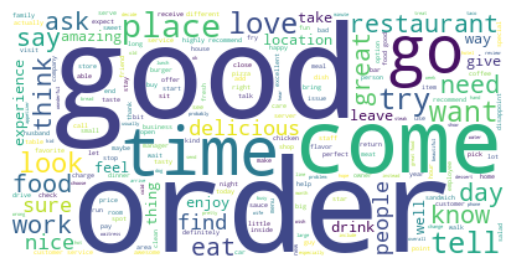

In [33]:
# word cloud
reviews_word_cloud = WordCloud(background_color="white").generate(' '.join(reviews_pandas_df['lemmas']))

# Display the generated wordcloud image
plt.imshow(reviews_word_cloud, interpolation='bilinear') 
plt.axis("off")

# Don't forget to show the final image
plt.show()

The larger the word, the more it appears in reviews e.g: good, come, order, time and so on

### 7. Save Processed Reviews

In [34]:
reviews_pandas_df.head()

,review_id,business_id,stars,categories,date,text,lemmas,num_lemmas,month,review_length,avg_word_length
0,mG1FavLfA5j2L83sCZ3rFg,drTZrkbpSoJgwKETlFbc3w,1.0,"Shopping, Musical Instrument Services, Musical...",2022-01-01 15:47:07,I bought a Fender 1966 Telecaster that the sal...,buy fender telecaster salesperson tell origina...,50,1,641,5.0
1,WMpnr1XBJ5U38rfSdErhJQ,jyxHti29yWdYR00Itt1A2w,5.0,"Restaurants, Mediterranean",2022-01-02 03:49:01,This is our go to for take out when I visit my...,visit son restaurant desert home food authenti...,14,1,208,4.0
2,99EMi0lRhdmylbG0soaf9w,Jo4ei-c-5H53IxZxAVf1jQ,5.0,"Hair Salons, Men's Hair Salons, Barbers, Beaut...",2022-01-03 03:17:03,Danielle did a great job! She listened and cu...,danielle great job listen cut hair way request...,24,1,278,4.0
3,Qs4z8e7hCoU9EzRKD9rGPQ,YT5CjacTllBtvMaMJS3IbA,1.0,"Hotels & Travel, Hotels, Venues & Event Spaces...",2022-01-05 15:55:59,We saw a lot of roaches in the bathroom when w...,see lot roach bathroom wake bed large dark sta...,38,1,514,4.0
4,SXZ2Nw9UGAgPlXJsju9fFA,9MHe5jAym2d8VhT_NbCRyw,2.0,"Restaurants, Chinese, Thai",2022-01-06 03:59:21,We Ordered pork fried rice and beef chow mei ...,order pork fry rice beef chow mei fun teriyaki...,16,1,148,5.0


In [35]:
# Save dataframe for further analysis
os.makedirs("processed", exist_ok=True)
reviews_pandas_df.to_parquet("processed/processed_reviews.parquet", index=False)